In [8]:
pip install findspark

In [7]:
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .appName("MyPySparkApp") \
        .master("local[*]") \
        .getOrCreate()



In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import findspark
findspark.init()

In [43]:
#Need to upload the file manually as I have prepared the notebook on google colab
from google.colab import files
uploaded = files.upload()

Saving nyc-jobs.csv to nyc-jobs (1).csv


In [58]:
data = spark.read.csv("nyc-jobs.csv", header=True, inferSchema = True, multiLine=True, quote='"',  escape='"')
data.printSchema()


root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

In [59]:
data.show(5)
data.columns

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+-----------+---------------+-------------------+---------------------+-------------------+----------+-------------------+-------------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|Hours/Shift|Work Location 1|Recruitment Contact|Residency Requirement|       Posting Date|Post Until|    Pos

['Job ID',
 'Agency',
 'Posting Type',
 '# Of Positions',
 'Business Title',
 'Civil Service Title',
 'Title Code No',
 'Level',
 'Job Category',
 'Full-Time/Part-Time indicator',
 'Salary Range From',
 'Salary Range To',
 'Salary Frequency',
 'Work Location',
 'Division/Work Unit',
 'Job Description',
 'Minimum Qual Requirements',
 'Preferred Skills',
 'Additional Information',
 'To Apply',
 'Hours/Shift',
 'Work Location 1',
 'Recruitment Contact',
 'Residency Requirement',
 'Posting Date',
 'Post Until',
 'Posting Updated',
 'Process Date']

In [60]:
data = data.withColumn(
    "Posting Date",
    expr("try_cast(`Posting Date` as date)")
)

In [61]:
data.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

# **Detailed Analysis of Dataset**

#1. Provide a detailed analysis of source data: Column values

In [62]:
num_cols = [] #using a list to store appended values
catg_cols = []
date_cols = []

for field in data.schema.fields:
    if isinstance(field.dataType, (IntegerType, DoubleType)):
        num_cols.append(field.name)
    elif isinstance(field.dataType, DateType):
        date_cols.append(field.name)
    else:
        catg_cols.append(field.name)

print("Total Numerical Columns", num_cols)
print("Total Categorical Columns:", catg_cols)
print("Total Date Columns:", date_cols)

Total Numerical Columns ['Job ID', '# Of Positions', 'Salary Range From', 'Salary Range To']
Total Categorical Columns: ['Agency', 'Posting Type', 'Business Title', 'Civil Service Title', 'Title Code No', 'Level', 'Job Category', 'Full-Time/Part-Time indicator', 'Salary Frequency', 'Work Location', 'Division/Work Unit', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills', 'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1', 'Recruitment Contact', 'Residency Requirement', 'Post Until', 'Posting Updated', 'Process Date']
Total Date Columns: ['Posting Date']


# **KPI**

#1. Whats the number of jobs posting per category (Top 10)?


In [63]:
jobs_posting = data.groupBy(col("Job Category")).agg(sum(col("# Of Positions")).alias("Total Positions")).orderBy(desc("Total Positions")).limit(10)

jobs_posting.show(truncate=False)

+-----------------------------------------+---------------+
|Job Category                             |Total Positions|
+-----------------------------------------+---------------+
|Public Safety, Inspections, & Enforcement|1407           |
|Building Operations & Maintenance        |1249           |
|Engineering, Architecture, & Planning    |762            |
|Legal Affairs                            |515            |
|Technology, Data & Innovation            |405            |
|Health                                   |358            |
|Administration & Human Resources         |330            |
|Finance, Accounting, & Procurement       |275            |
|Maintenance & Operations                 |212            |
|Policy, Research & Analysis              |200            |
+-----------------------------------------+---------------+



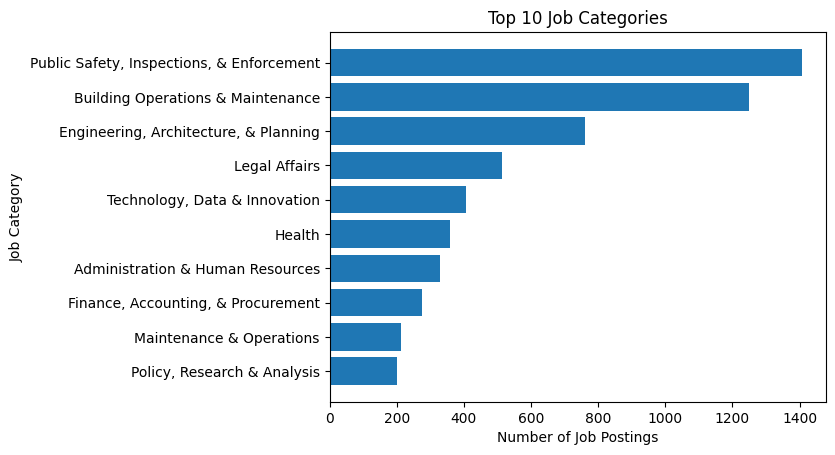

In [64]:
top_job_catg = jobs_posting.toPandas()

plt.figure()
plt.barh(top_job_catg["Job Category"], top_job_catg["Total Positions"])
plt.xlabel("Number of Job Postings")
plt.ylabel("Job Category")
plt.title("Top 10 Job Categories")
plt.gca().invert_yaxis()
plt.show()

#2. Salary Distribution per Job Category

In [65]:
salary_data = data.withColumn(
    "Average Salary",
    (col("Salary Range From") + col("Salary Range To")) / 2
)

salary_by_category = salary_data.groupBy("Job Category") \
    .agg(avg("Average Salary").alias("Avg Salary")) \
    .orderBy(desc("Avg Salary"))

salary_by_category.show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Job Category                                                                                                                                                                                             |Avg Salary        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance                                                                                                    |218587.0          |
|Engineering, Architecture, & Planning Maintenance & Operations                                             

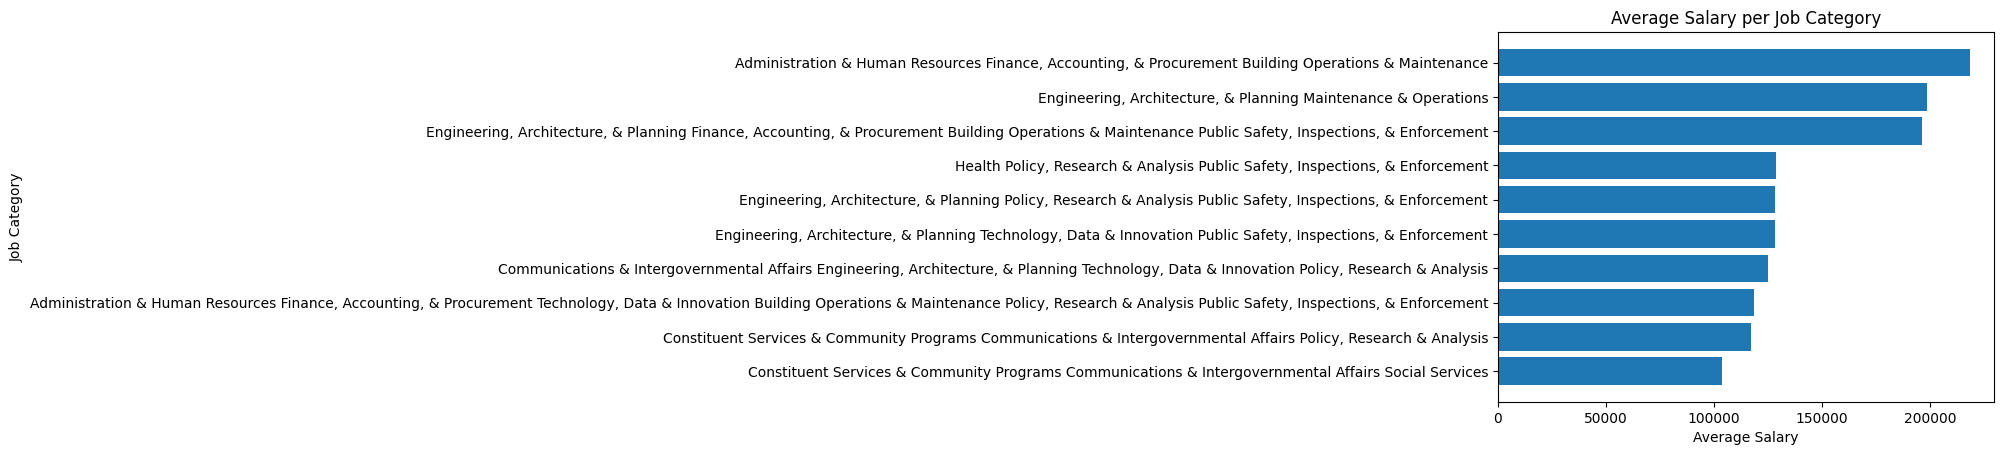

In [66]:
salary_pd = salary_by_category.limit(10).toPandas()

plt.figure()
plt.barh(salary_pd["Job Category"], salary_pd["Avg Salary"])
plt.xlabel("Average Salary")
plt.ylabel("Job Category")
plt.title("Average Salary per Job Category")
plt.gca().invert_yaxis()
plt.show()

#3. Correlation: Higher Degree vs Salary

In [67]:
degree_df = salary_data.withColumn(
    "Has_Higher_Degree",
    when(col("Minimum Qual Requirements").rlike("Bachelor|Master|PhD"), 1).otherwise(0)
)

degree_df.stat.corr("Has_Higher_Degree", "Average Salary")

0.0991540245867495

In [68]:
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("Agency").orderBy(desc("Average Salary"))

highest_salary = degree_df.withColumn("rank", rank().over(windowSpec)) \
    .filter(col("rank") == 1) \
    .select("Agency", "Business Title", "Average Salary")

highest_salary.show(truncate=False)

+-----------------------------+-----------------------------------------------------+--------------+
|Agency                       |Business Title                                       |Average Salary|
+-----------------------------+-----------------------------------------------------+--------------+
|ADMIN FOR CHILDREN'S SVCS    |Assistant Commissioner                               |117474.5      |
|ADMIN TRIALS AND HEARINGS    |Assistant General Counsel                            |90000.0       |
|ADMIN TRIALS AND HEARINGS    |Assistant General Counsel                            |90000.0       |
|BOARD OF CORRECTION          |IT Systems Support Engineer                          |96222.5       |
|BOARD OF CORRECTION          |IT Systems Support Engineer                          |96222.5       |
|BOROUGH PRESIDENT-QUEENS     |Engineering                                          |80526.5       |
|BOROUGH PRESIDENT-QUEENS     |Engineering                                          |80526.

#4. Average Salary per Agency (Last 2 Years)

In [69]:
posting_data = degree_df.withColumn("Posting Date", to_date("Posting Date"))

In [70]:
last_2_years = posting_data.filter(
    col("Posting Date") >= add_months(current_date(), -24)
)

avg_salary_agency = last_2_years.groupBy("Agency") \
    .agg(avg("Average Salary").alias("Avg Salary")) \
    .orderBy(desc("Avg Salary"))

avg_salary_agency.show()

+------+----------+
|Agency|Avg Salary|
+------+----------+
+------+----------+



#6. Highest Paid Skills (Text Mining)

In [71]:
from pyspark.sql.functions import explode, split, lower

skills_df = posting_data.select(
    explode(split(lower(col("Preferred Skills")), ",")).alias("Skill"),
    col("Average Salary")
)

highest_paid_skills = skills_df.groupBy("Skill") \
    .agg(avg("Average Salary").alias("Avg Salary")) \
    .orderBy(desc("Avg Salary"))

highest_paid_skills.show(10)

+--------------------+----------+
|               Skill|Avg Salary|
+--------------------+----------+
| develop and reta...|  218587.0|
| continuous impro...|  218587.0|
| and implement ac...|  218587.0|
| results-driven e...|  218587.0|
| he/she must be a...|  218587.0|
| communication an...|  218587.0|
| the following sk...|  218587.0|
| of which at leas...|  218587.0|
| city and state g...|  218587.0|
|   diagnose problems|  218587.0|
+--------------------+----------+
only showing top 10 rows


# PART 2 — DATA PROCESSING

#1. Cleaning Function

In [72]:
def clean_data(df):
    df = posting_data.dropDuplicates()
    df = df.fillna({
        "Salary Range From": 0,
        "Salary Range To": 0
    })
    return df

#2. Column Preprocessing

In [73]:
def preprocess_columns(df):
    df = df.withColumn(
        "Average Salary",
        (col("Salary Range From") + col("Salary Range To")) / 2
    )
    df = df.withColumn("Posting Date", to_date("Posting Date"))
    return df

#3. Feature Engineering (At least 3)

In [74]:
df = posting_data.withColumn(
    "Salary Range Width",
    col("Salary Range To") - col("Salary Range From")
)

#4. Feature 2: Degree Requirement Binary

In [75]:
df = df.withColumn(
    "Requires Degree",
    when(col("Minimum Qual Requirements").rlike("Bachelor|Master|PhD"), 1).otherwise(0)
)

#5. Feature 3: Posting Year

In [76]:
df = df.withColumn("Posting Year", year(col("Posting Date")))


#6. Feature Removal

In [77]:
columns_to_remove = [
    "Recruitment Contact",
    "To Apply",
    "Additional Information"
]

df = df.drop(*columns_to_remove)

#7. Store Processed Data

In [79]:
df.write.mode("overwrite").csv("processed_nyc_jobs.csv", header=True)


#8. Test Cases

In [80]:
assert df.count() > 0, "Dataset is empty!"
assert "Average Salary" in df.columns, "Feature not created!"
assert df.filter(col("Average Salary") < 0).count() == 0, "Negative salary found!"